## 使用RNN进行文本分类 - Try LSTM

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf

import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 80
pd.options.display.precision = 4
pd.options.display.max_rows = 999
pd.options.display.float_format = '{:.10f}'.format
%matplotlib notebook

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [11]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [35]:
train_dataset1, test_dataset1 = dataset['train'], dataset['test']

In [36]:
type(train_dataset1)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [39]:
for string_, int_ in train_dataset1:
    print(string_)
    print(int_)
    break

tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975], shape=(163,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [40]:
string_.shape

TensorShape([163])

In [12]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [15]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))


Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [16]:
assert original_string == sample_string

In [17]:
for index in encoded_string:
    print('{} ----&gt; {}'.format(index, encoder.decode([index])))

4025 ----&gt; Hell
222 ----&gt; o 
6307 ----&gt; Ten
2327 ----&gt; sor
4043 ----&gt; Fl
2120 ----&gt; ow
7975 ----&gt; .


In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [20]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### 创建模型

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 528s 1s/step - loss: 0.6347 - accuracy: 0.5890 - val_loss: 0.5133 - val_accuracy: 0.7802
Epoch 2/10
391/391 [==============================] - 457s 1s/step - loss: 0.3468 - accuracy: 0.8554 - val_loss: 0.3447 - val_accuracy: 0.8562
Epoch 3/10
391/391 [==============================] - 457s 1s/step - loss: 0.2528 - accuracy: 0.9012 - val_loss: 0.3758 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 451s 1s/step - loss: 0.2132 - accuracy: 0.9205 - val_loss: 0.3381 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 479s 1s/step - loss: 0.1923 - accuracy: 0.9292 - val_loss: 0.3314 - val_accuracy: 0.8677
Epoch 6/10
391/391 [==============================] - 523s 1s/step - loss: 0.1614 - accuracy: 0.9425 - val_loss: 0.4205 - val_accuracy: 0.8734
Epoch 7/10
391/391 [==============================] - 486s 1s/step - loss: 0.1440 - accuracy: 0.9502 - val_loss: 0.3804 - val_accuracy: 0.8651

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 128s 327ms/step - loss: 0.4548 - accuracy: 0.8514
Test Loss: 0.45482274889945984
Test Accuracy: 0.8514400124549866


In [25]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [26]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.23607999]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.20179051]]


<IPython.core.display.Javascript object>


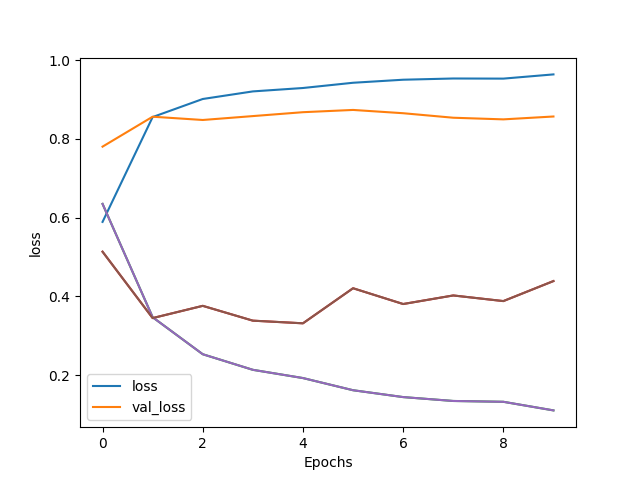

In [29]:
plot_graphs(history, 'accuracy')

In [31]:
plot_graphs(history, 'loss')